# Identifying Tactical Graphics via Machine Learning Classification - Part 2
## By: Matthew Jacobsen, updated: 5/28/2020

Welcome to the second part of this walkthrough! As you'll recall from Part 1, we are working to build a machine learning classifier for the automated characterization of tactical graphics, as part of enhancing the evaluation of command and control systems for military purposes. In Part 1, we created a set of graphics that can be used to train and test our machine learning classifier.  

In Part 2, we will work our way through the actual process of preparing the data set, creating the classifier, and training it.  By the end of this part, we will have a working classifier and some idea how accurate it is for the most generic of tactical graphics. In order to accomplish this, we will start by appropriately arranging the data into a format for the Scikit Learn package.  Then, we will construct our classifier and train it.  Finally, we will test the accuracy against a set of validation data that the classifier will not have seen before.  

Let's get started, shall we?

### Preparing the Training Dataset

As an outcome of Part 1, we created the images that would be used for training our algorithm. While we can use these on their own, the goal is to make this process usable outside of this walkthrough, so we'll do a little more work to make this information more easy to use. In addition to adding the various data elements to this data dictionary, we will also resize any images that happened to be larger than 40x40 pixels. Given that we are using 2525c standard graphics, we'll name these as such and pickle them for later use. 

In [1]:
def label_onehot_encoding(index):
    cur_list = [0,0,0,0,0,0,0]
    cur_list[index-1] = 1
    return np.asarray(cur_list)

100%|███████████████████████████████████████████████████████████████████████████| 32963/32963 [00:47<00:00, 690.42it/s]


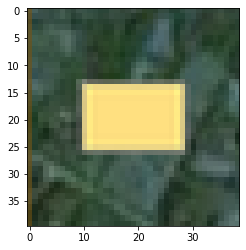

In [2]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import cv2
import pickle
import numpy as np
from tqdm import tqdm

os.chdir(r'C:\Users\Matt\Documents\Personal File\Python Code Packages\Tool Assisted Analysis Suite\GraphicIdentificationMachineLearning\testset')

training_data = []
labels = []

OUTSIZE = 40
for file in tqdm(os.listdir()):
    img = cv2.imread(file)
    label = file[:file.find('_')]
    if label not in labels:
        labels.append(label)
        lbl_idx = labels.index(label)
    else:
        lbl_idx = labels.index(label)
    adj_img = cv2.resize(img, (OUTSIZE, OUTSIZE))
    training_data.append([adj_img, label_onehot_encoding(lbl_idx)])


In order to maintain the separation between our validation and training data, we will repeat this process and create a separate pickled dataset for the validation images.  

In [3]:
os.chdir(r'C:\Users\Matt\Documents\Personal File\Python Code Packages\Tool Assisted Analysis Suite\GraphicIdentificationMachineLearning\validationset')

validation_data = []

OUTSIZE = 40

for file in tqdm(os.listdir()):
    img = cv2.imread(file)
    label = file[:file.find('_')]
    lbl_idx = labels.index(label)
    adj_img = cv2.resize(img, (OUTSIZE, OUTSIZE))
    validation_data.append([adj_img, label_onehot_encoding(lbl_idx)])
    

100%|██████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 1670.08it/s]


### Preparing the X and y data sets for Training

Now that we have our data imported, we'll have to do some manipulation in order to get it into a format and order that will work well for the training.  First, let's import the packages we need for this section.

In [4]:
%matplotlib inline
 
import numpy as np
import matplotlib.pyplot as plt
import random

Just to illustrate what type of problem we'd have if we trained our classifier right now, let's look at our encoded labels.  Recall that each column is one of our affiliation labels, so let's see what we've got right now.

In [5]:
for item in training_data[:10]:
    print(item[1])

[0 0 0 0 0 0 1]
[0 0 0 0 0 0 1]
[0 0 0 0 0 0 1]
[0 0 0 0 0 0 1]
[0 0 0 0 0 0 1]
[0 0 0 0 0 0 1]
[0 0 0 0 0 0 1]
[0 0 0 0 0 0 1]
[0 0 0 0 0 0 1]
[0 0 0 0 0 0 1]


For the record, we should expect this.  Our code for compiling the information in the previous section was sequential and would have gone in the order the files are displayed in a file browser (so, alphabetical and numerically ordered).  Let's take care of that before moving on.  

In [6]:
random.shuffle(training_data)

for item in training_data[:10]:
    print(item[1])

[0 0 0 0 0 0 1]
[1 0 0 0 0 0 0]
[1 0 0 0 0 0 0]
[0 0 0 0 0 1 0]
[0 0 0 1 0 0 0]
[0 0 1 0 0 0 0]
[0 0 0 0 0 0 1]
[0 0 0 0 0 1 0]
[0 0 0 0 0 1 0]
[0 0 1 0 0 0 0]


That's better. However, why would we want to do this? If we had proceeded, the classifier would have learned to predict everything as the last category, then the next, then the next, and on and on.  At the end, it would have uniformly predicted a single class for everything, which is not very useful. 

Next, let's get our inputs and labels ready for the classifier.  We'll go through and separate the lists into X (inputs) and y (labels).  We'll also need to reshape the X array and normalize by dividing by 255.0 (the max value for a pixel is 255 in any of the colors).  We'll also convert y to a Numpy array and then pickle the data so we don't have to do all this work again.

In [15]:
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)


X = np.array(X).reshape(-1, OUTSIZE, OUTSIZE, 3)

X = X/255.0
y = np.asarray(y)

with open('milstd2525c_training_X.pkl','wb') as outfile:
    pickle.dump(X, outfile, protocol=2)


with open('milstd2525c_training_y.pkl','wb') as outfile:
    pickle.dump(y, outfile, protocol=2)

Just to illustrate again that what we've got are images and labels, let's show an example.  

Anticipated


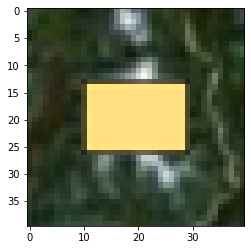

In [16]:
y_idx = y[1]
print(labels[list(y_idx).index(1)])
plt.imshow(X[1])

Also to check that the images are, as we expect 40 by 40 pixels, with 3 color channels (Red, Green, and Blue), let's take a look. 

In [17]:
img = X[0]
img.shape

(40, 40, 3)

Now we are mostly ready for building our classifier.  

### Training the Classifier

As there are many examples of how to do image classification online, it should come as no surprise that we are going to be building a Convolutional Neural Network for this task.  First, let's import our packages, which include pickle, matplotlib, os, and tensforflow (along with several sub-packages).  For now, we'll stick with a more canned example, but later on we'll take a look at how to optimize this. Recall that there are **lots** of graphics that will need classification, so optimization will be necessary later on. 

In [18]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten,Conv2D,MaxPooling2D

import os
import pickle
import matplotlib.pyplot as plt

os.chdir(r'C:\Users\Matt\Documents\Personal File\Python Code Packages\Tool Assisted Analysis Suite\GraphicIdentificationMachineLearning')

Now, let's build our sequential neural network model.  We start by telling python that it is sequential, then use a convolutional layer, followed by an activation layer and a MaxPooling layer.  These effectively take the image data and start to search for features that would help to identify what we are trying to classify. For the moment, we'll use a two layer network, although we could do more or less.

After going through this, we need to flatten our 2D information into one dimension and then pass to two dense neuron layers.  The first is used to accumulate the information learned from the convolutional layers, with the last one being our predictive layer.  Finally, we give the output layer an activation.  

We'll then build the network using categorical_crossentropy as the loss function (since we are doing a categorical model).  We'll use the adam optimizer and use accuracy for the metric.  

In [22]:
model = Sequential()

model.add(Conv2D(256, kernel_size=(3,3), input_shape=X.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256, kernel_size=(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128))
model.add(Dense(len(labels)))
model.add(Activation('sigmoid'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

Let's fit that puppy and see how we do.  We'll start off with two epochs through the data and a 20% split for the test based validation data.

In [23]:
model.fit(X,y, epochs=2, validation_split=0.2)

Epoch 1/2
825/825 [==============================] - 332s 403ms/step - loss: 0.0598 - accuracy: 0.9749 - val_loss: 1.2088e-04 - val_accuracy: 1.0000
Epoch 2/2
825/825 [==============================] - 396s 480ms/step - loss: 3.9408e-05 - accuracy: 1.0000 - val_loss: 2.5672e-05 - val_accuracy: 1.0000


So, after two epochs, the classifier appears to be able to predict with relatively high accuracy what the affiliation of our graphics is.  In the next section, we'll test that with our separate validation data.  For now, let's save the model out, so we have a record.

In [88]:
model.save('aff_model.h5')

### Testing the Classifier

Althogh we were performing validation in the previous section by splitting our training data, recall that we also prepared a validation set to use for this purpose.  Let's see how our classifier does in this case.  We start by processing the validation data set in the same way that we did the training data set.  

In [24]:
X_val = []
y_val = []

for features,label in validation_data:
    X_val.append(features)
    y_val.append(label)


X_val = np.array(X_val).reshape(-1, OUTSIZE, OUTSIZE, 3)

X_val = X_val/255.0
y_val = np.asarray(y_val)

Just to show that the data is the same as the validation data (as far as a graphic overlaid on a map image, with a label), here's an example. 

Anticipated


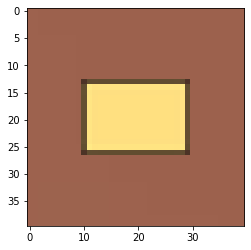

In [53]:
print(labels[np.argmax(y_val[20])])
plt.imshow(X_val[20])

Now, we'll go through one at a time and process the images to get the neural network classification of that image.  This will be put into a list, with the structure [Predicted Label, Actual Label, Correct or Not].  

In [81]:
y_pred_hat = []
y_val_results = []
i = 0
for i in range(len(X_val)):
    y_pred = model.predict(X_val[i].reshape(-1, OUTSIZE, OUTSIZE, 3))
    y_pred_hat.append(labels[np.argmax(y_pred)])
    y_val_label = labels[np.argmax(y_val[i])]
    if y_val_label == labels[np.argmax(y_pred)]:
        y_val_results.append([labels[np.argmax(y_pred)], y_val_label, 1])
    else:
        
        y_val_results.append([labels[np.argmax(y_pred)], y_val_label, 0])
    i+=1

In order to visualize this information, we can use Pandas to convert that list into a fancy DataFrame with column labels.  This will also make our statistics easier to perform. 

In [86]:
import pandas as pd
df = pd.DataFrame(y_val_results, columns=['Prediction','Actual','Binary Agreement'])
df

,Prediction,Actual,Binary Agreement
0,Unknown,Unknown,1
1,Unknown,Unknown,1
2,Unknown,Unknown,1
3,Unknown,Unknown,1
4,Unknown,Unknown,1
...,...,...,...
100,Suspect,Suspect,1
101,Suspect,Suspect,1
102,Suspect,Suspect,1
103,Suspect,Suspect,1


In [87]:
df.describe()

,Binary Agreement
count,105.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


So, we are still flying high with this.  With 105 sample images to validate against, the classifier got all of them right.  While there are some caveats to this way of doing things, this is still a pretty impressive result.  

### Caveats of Use

As was mentioned earlier, there are some caveats to the use of this example classifier.  Some of the standout issues that we glossed over in this tutorial include:

 - The volume of graphics: There is a *huge* volume of military standard graphics to classify.  We could build a single neural network that would try to classify them all, but this is likely going to be a ridiculous task and won't really help us. 
 
 - The variability of graphics: The examples we used all represent a generic **land military unit**. In part, this is because it reduces the problem space significantly, but it is a simplification that we need to be aware of.  
 

So, how can we construct a neural network that can handle this full task? While you may come up with a different answer, my answer to this was *don't*. From all the available literature on neural networks, it is clear that trying to build a once-over-the-moon classifier is likely to result in poor performance, an unwieldly neural network, and a very high data burden.  

So, do we give up? Of course not! Let's get creative instead.  If we can (as shown here) train a classifier to label individual aspects of a graphic, based on sequential features, then we can build a hybrid classifier/decision tree (although the decision tree part is more us hardwiring the sequence) that handles features one at a time and progressively determines the label. This makes sure that (1) the problem space for each classifier is relatively small and (2) that each classifier has a small number of labels it is attempting to apply. 


### Conclusion

In this walkthrough, we have covered a generic example of how to classify military graphics using machine learning techniques.  We started by obtaining the data needed, including military graphic symbology from one webside and how to merge that with automated backgrounds from Google Earth.  Then, we standardized that data and fed it into a convolutional neural network to train it on how to extract the affiliation of the graphic.  Finally, we validated that the neural network was able to accurately predict the affiliation of the graphic.  

As with the other examples of work I have posted, I am humbled by your interest in reading this much of my work and appreciate your attention. If you have ideas or suggestions, or want to ask questions, feel free to send an email.  My contact information is on my (website)[mkjacobsen.github.io].  